In [84]:
import cv2
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [85]:
plt.rcParams['figure.figsize'] = [7, 7]

In [86]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

In [87]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

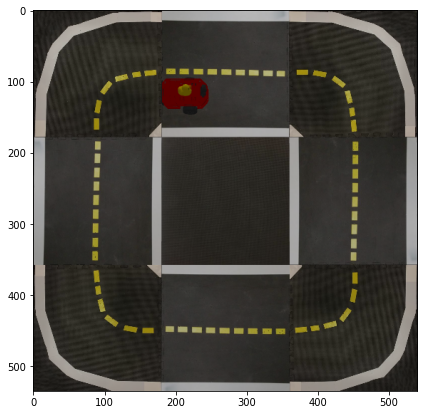

In [88]:
env.reset()
top_view = np.flip(env.render(mode="top_down"), [0])[35:-30,130:-130]
plt.imshow(top_view)

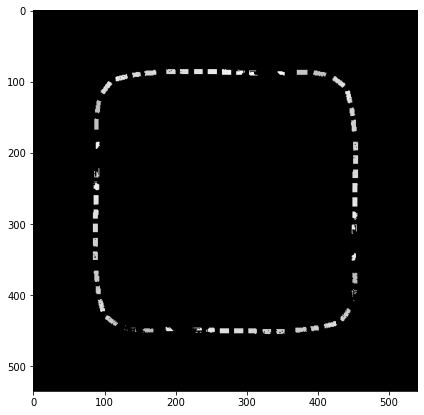

In [89]:
img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

lower_yellow = np.array([20,100,150])
upper_yellow = np.array([30,255,255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask = cv2.bitwise_and(gray, mask_yellow)

plt.imshow(mask, cmap='gray')

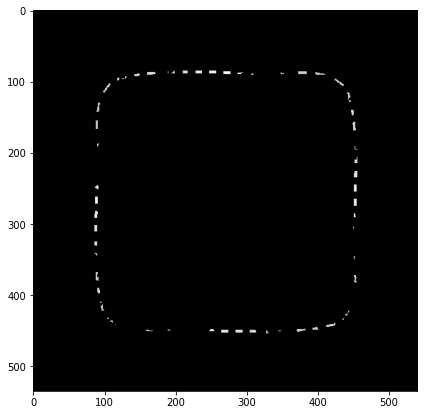

In [90]:
kernel = np.ones((4, 4), np.uint8)
eroded = cv2.erode(mask, kernel) 
plt.imshow(eroded, cmap='gray')

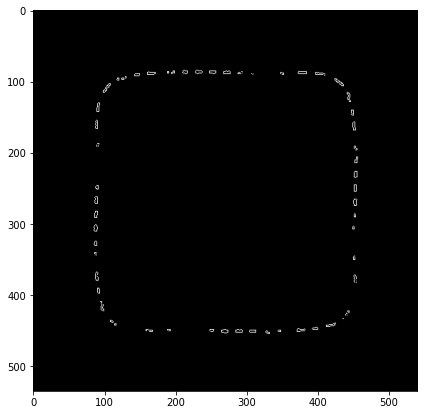

In [91]:
low_threshold = 89
high_threshold = 80
edges = cv2.Canny(eroded, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

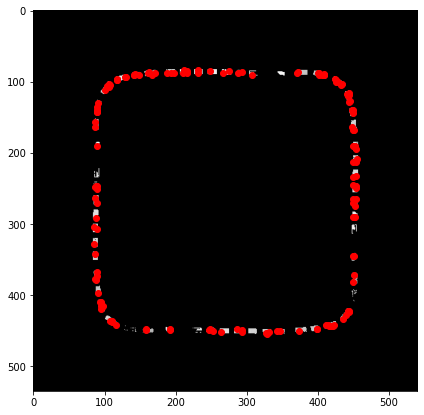

In [92]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 3  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

_points = lines.reshape(-1, 2)

x, y = _points.T
plt.scatter(x, y, zorder=1, color="r")
plt.imshow(mask, zorder=0, cmap='gray')

In [93]:
def sort_xy(x, y, return_origin=False):
    """
    Sort by angle

    :param return_origin: If true returns also the computed origin
    """

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    if return_origin:
        return x_sorted, y_sorted, x0, y0

    return x_sorted, y_sorted

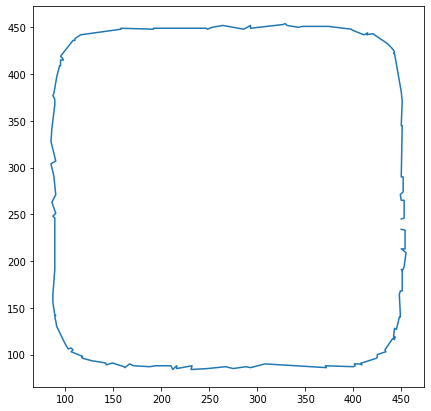

In [94]:
x_all, y_all = np.nonzero(mask)
x_sorted, y_sorted = sort_xy(x, y)
plt.plot(x_sorted, y_sorted)

In [95]:
from scipy.interpolate import interp1d

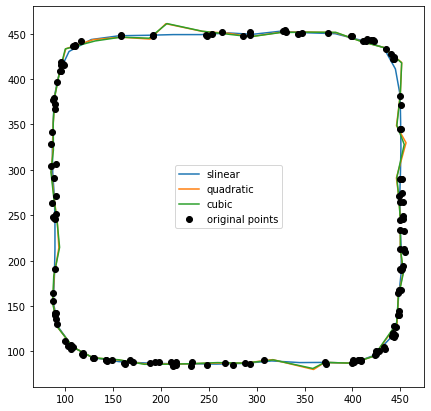

In [96]:
points = np.array([x_sorted, y_sorted]).T  # a (nbre_points x nbre_dim) array

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
interpolations_methods = ['slinear', 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 50)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name)

plt.plot(*points.T, 'ok', label='original points')
plt.legend()

In [97]:
from scipy.interpolate import UnivariateSpline

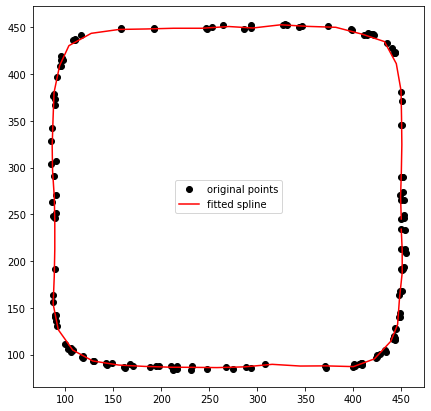

In [98]:
# https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

points = np.array([x_sorted, y_sorted]).T

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Build a list of the spline function, one for each dimension:
# k is the degree of the spline. 3 means cubic
splines = [UnivariateSpline(distance, coords, k=1, s=.01) for coords in points.T]

# Computed the spline for the asked distances:
alpha = np.linspace(0, 1, 50)
points_fitted = np.vstack( spl(alpha) for spl in splines ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points')
plt.plot(*points_fitted.T, '-r', label='fitted spline')
plt.legend()

In [99]:
def get_angles(x, y, x0=None, y0=None):
    """
    Get the angles of the trajectory.
    
    :param x: x coordinates
    :param y: y coordinates
    :param x0: x coordinate of the origin
    :param y0: y coordinate of the origin
    """

    if x0 is None:
        x0 = np.mean(x)
    if y0 is None:
        y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    return angles

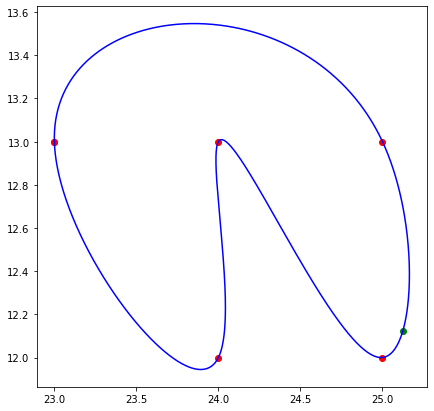

In [100]:
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt

x = np.array([23, 24, 24, 25, 25])
y = np.array([13, 12, 13, 12, 13])

# append the starting x,y coordinates
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
# is needed in order to force the spline fit to pass through all the input points.
tck, u = interpolate.splprep([x, y], s=0, per=True)

# evaluate the spline fits for 1000 evenly spaced distance values
xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)

# plot the result
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'or')
ax.plot(xi, yi, '-b')

ax.scatter(*interpolate.splev([0.6], tck), c="g")

In [101]:
get_angles(x,y)

array([2.8198421 , 4.71238898, 1.57079633, 5.6951827 , 0.32175055,
       2.8198421 ])

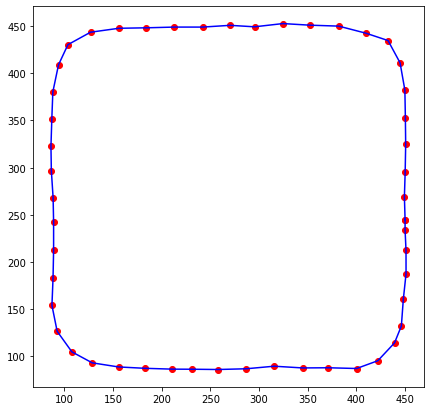

In [102]:
x, y = points_fitted.T

# append the starting x,y coordinates
x = np.r_[x, x[0]]
y = np.r_[y, y[0]]

# fit splines to x=f(u) and y=g(u), treating both as periodic. also note that s=0
# is needed in order to force the spline fit to pass through all the input points.
tck, u = interpolate.splprep([x, y], s=0, per=True, task=0)

xi, yi = interpolate.splev(u, tck)

# t_new, u_new = interpolate.splprep([[200], [100]], u=u, t=tck, task=-1)
# x_new, y_new = interpolate.splev(u_new, t_new)

# plot the result
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'or')
ax.plot(xi, yi, '-b')
# ax.scatter(x_new, y_new, c="g")

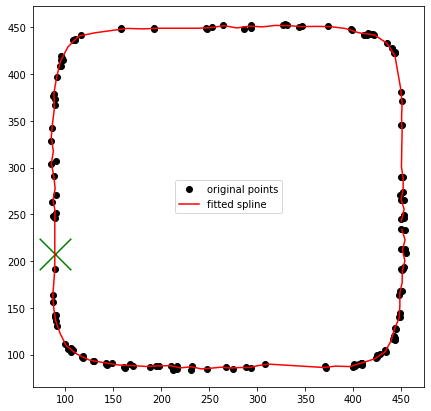

In [110]:
# My version working with angles
x, y = _points.T
x_sorted, y_sorted, x0, y0 = sort_xy(x, y, return_origin=True)

angles = get_angles(x_sorted, y_sorted, x0=x0, y0=y0)

angles = np.concatenate([[0], angles, [2*np.pi]])
x_sorted = np.concatenate([[x_sorted[-1]], x_sorted, [x_sorted[0]]])
y_sorted = np.concatenate([[y_sorted[-1]], y_sorted, [y_sorted[0]]])

# Build a list of the spline function, one for each dimension:
# k is the degree of the spline. 3 means cubic
spline_x = UnivariateSpline(angles, x_sorted, k=1, s=.01)
spline_y = UnivariateSpline(angles, y_sorted, k=1, s=.01)

# Computed the spline for the asked distances:
points_fitted = np.vstack( spl(np.linspace(0.01, 6.23, 100)) for spl in [spline_x, spline_y] ).T

# Graph:
plt.plot(*points.T, 'ok', label='original points')
plt.plot(*points_fitted.T, '-r', label='fitted spline')

# Test
angle = get_angles([100], [210], x0=x0, y0=y0)
plt.scatter(spline_x(angle)[0], spline_y(angle)[0], c="g", marker="x", s=1000)
plt.legend()

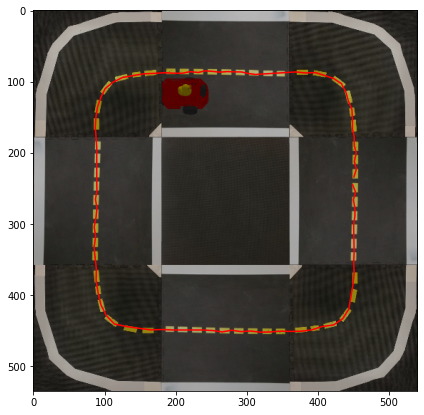

In [105]:
plt.imshow(top_view)
plt.plot(*points_fitted.T, '-r')